# Setup

In [2]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from numpy.random import dirichlet as diri
from scipy import stats

plt.style.use("seaborn-darkgrid")
dl = DataLib("SignalData")

In [3]:
# Pull all the necessary dataframes to avoid duplicate code. 
BondRetIdx = dl.pull("BondRetIdx/LocalFX")
LongRates = dl.pull("LongRates")
ShortRates = dl.pull("ShortRates")
EquityPrices = dl.pull("EquityPrices")
M1 = dl.pull("M1/inUSD")
M2 = dl.pull("M2/inUSD")
M3 = dl.pull("M3/inUSD")
CurrAcctNom = dl.pull("CurrAcctNom/inUSD")
CurrAcctPctGDP = dl.pull("CurrAcctPctGDP")
nGDP = dl.pull("GDP/Nominal")
rGDP = dl.pull("GDP/Real")
nFxTrdWts = dl.pull("fxTrdWts/Nominal")
rFxTrdWts = dl.pull("fxTrdWts/Real")
fxVsUSD = dl.pull("fxVsUSD")
CoreCPI = dl.pull("CoreCPI/SA")
rfRates = dl.pull("RiskfreeRates")

In [4]:
# Constants. 
WORKDAYS_IN_MONTH=21
WORKDAYS_IN_YEAR=261
QUARTERS_IN_YEAR=4
COUNTRIES=[
    'USA', 'AUS', 'JPN', 'CAN', 'CHE', 'GBR', 'ESP', 'FRA', 'ITA', 'DEU'
]

# Utility Functions

In [5]:
def get_sharpe(country): 
    
    risk_adjusted_returns = get_risk_adjusted_returns()
    returns = risk_adjusted_returns
    gmean = stats.gmean((1 + returns[country]).dropna())
    annualized_return = (gmean ** 261) - 1
    risk = returns[country].std() * np.sqrt(261)
    
    return annualized_return/risk

def get_risk_adjusted_returns():

    # Convert from monthly to daily rf rates.
    series = rfRates / 100
    series = series.resample('B').ffill()
    series = (series + 1) ** (1 / WORKDAYS_IN_YEAR) - 1
    series = series.loc[bri.index]
    
    # Convert this series to a dataframe.
    rf_rates = bri.copy()
    for country in rf_rates.columns.values: 
        rf_rates[country] = series
        
    # Subtract the rates from the change in bond returns. 
    return bri.pct_change() - rf_rates

# Sample Returns Stream
To speed up development, here we're going to make a two dummy signals. Our signal will be a time series of data telling us how long and how short to go in each bond market. Our long and short positions must be offsetting. We will use two dummy signals: 
- An equal weighting scheme (all long)
- A randomly weighted scheme using a Dirichlet distribution (equal long/short)

In [7]:
# Get the data (just use the year 2000 for simplicity).
bri = dl.pull("BondRetIdx/LocalFX")
index = bri.index
mask = (index >= '2000-1-1') & (index < '2011-1-1')
df = bri.loc[mask]

Text(0.5, 0, 'Date')

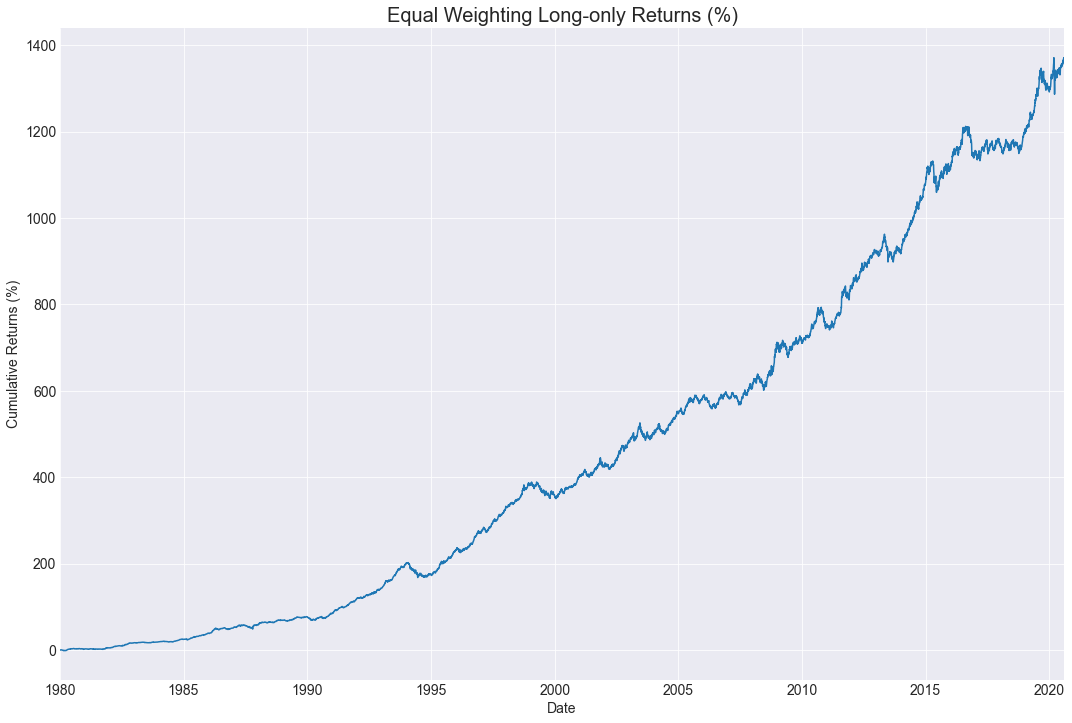

In [8]:
# Calculate our returns using an equal-weighted long-only scheme. 
bri_chg = bri.pct_change()
equal_weight_returns = (0.1 * bri_chg).sum(axis=1)
cumul_returns = ((equal_weight_returns + 1).cumprod() - 1) * 100
ax = cumul_returns.plot(title='Equal Weighting Long-only Returns (%)', figsize=(18, 12), fontsize=14)
ax.title.set_size(20)
ax.set_ylabel('Cumulative Returns (%)', fontsize=14)
ax.set_xlabel('Date', fontsize=14)

In [9]:
sharpe = np.mean([get_sharpe(country) for country in COUNTRIES])
print('sharpe:', sharpe)

sharpe: 0.5891421614215856


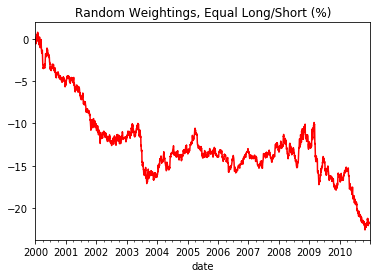

In [42]:
# Random signal with equal longs and shorts (every day).
signal = pd.DataFrame(df)
for ind in df.index: 
    arr = np.append(diri(np.ones(5),size=1), -1*diri(np.ones(5),size=1))
    np.random.shuffle(arr)
    signal.at[ind] = arr

abbr_returns = abbr_returns.shift(-1)                # Shift returns back by one day. 
returns = (signal * abbr_returns).sum(axis=1)        # Calculate the returns. 
cumul_returns = ((returns + 1).cumprod() - 1) * 100  # Get cumulative returns. 

# Plot. 
cumul_returns.plot(title="Random Weightings, Equal Long/Short (%)", color='red')